In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag #taking bootstrat
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

## Data 

DC Housing Price data. 

In [2]:
# Test Data on Housing Prices in DC
test = pd.read_csv("/Users/juliezantao/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")
test.shape

(14531, 39)

In [3]:
# Train Data on Housing Prices in DC
train = pd.read_csv("/Users/juliezantao/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")
train.shape

(43590, 39)

In [4]:
# Available features
list(test)
list(train)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

<AxesSubplot:>

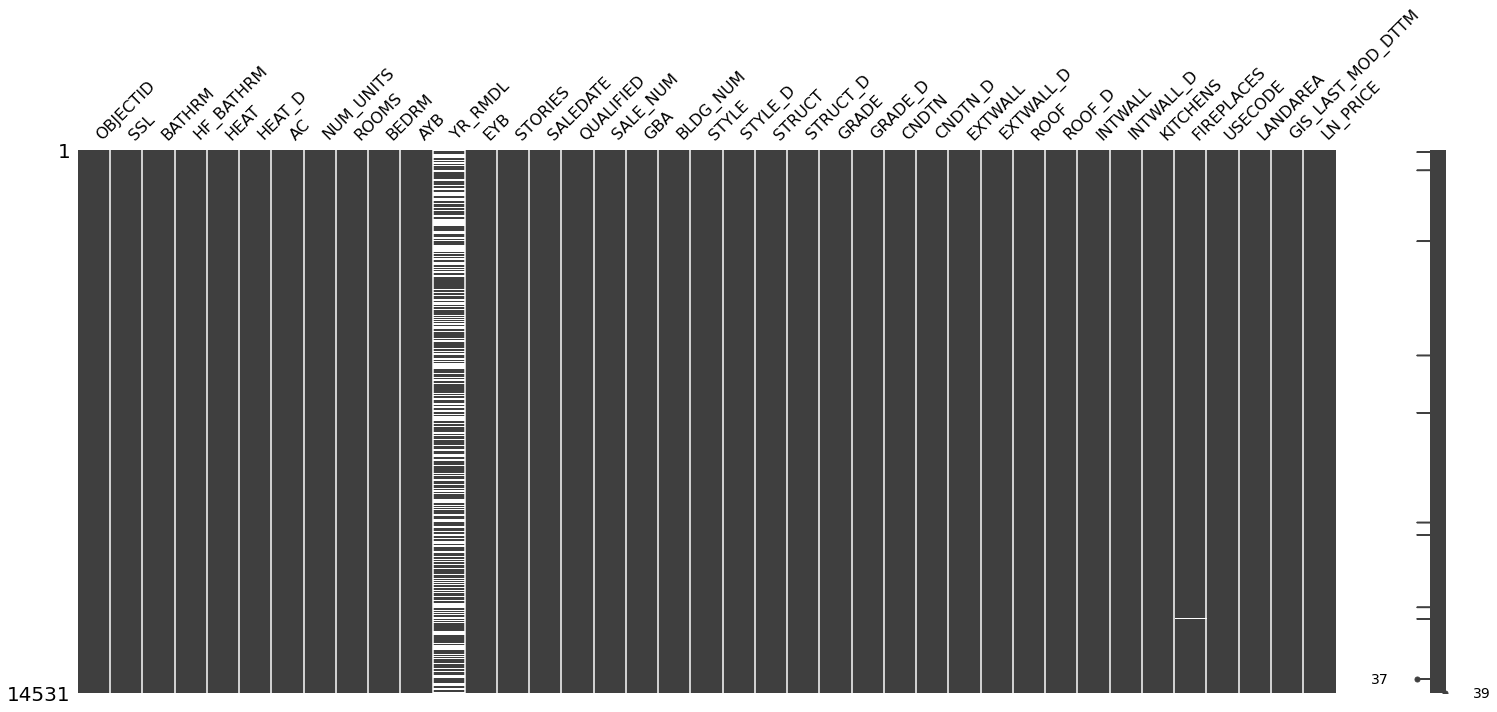

In [5]:
miss.matrix(test)

In [6]:
# Drop all observations where the outcome is missing 
test = test[~test.LN_PRICE.isna()]
train = test[~test.LN_PRICE.isna()]

# Only houses that are sold
test = test[test.LN_PRICE > 0]
train = train[train.LN_PRICE > 0]

In [7]:
# PREDICTORS: simplified for our purposes

test = test[['LN_PRICE','BATHRM','ROOMS','LANDAREA','FIREPLACES']] 
train = train[['LN_PRICE','BATHRM','ROOMS','LANDAREA','FIREPLACES']] 


<AxesSubplot:>

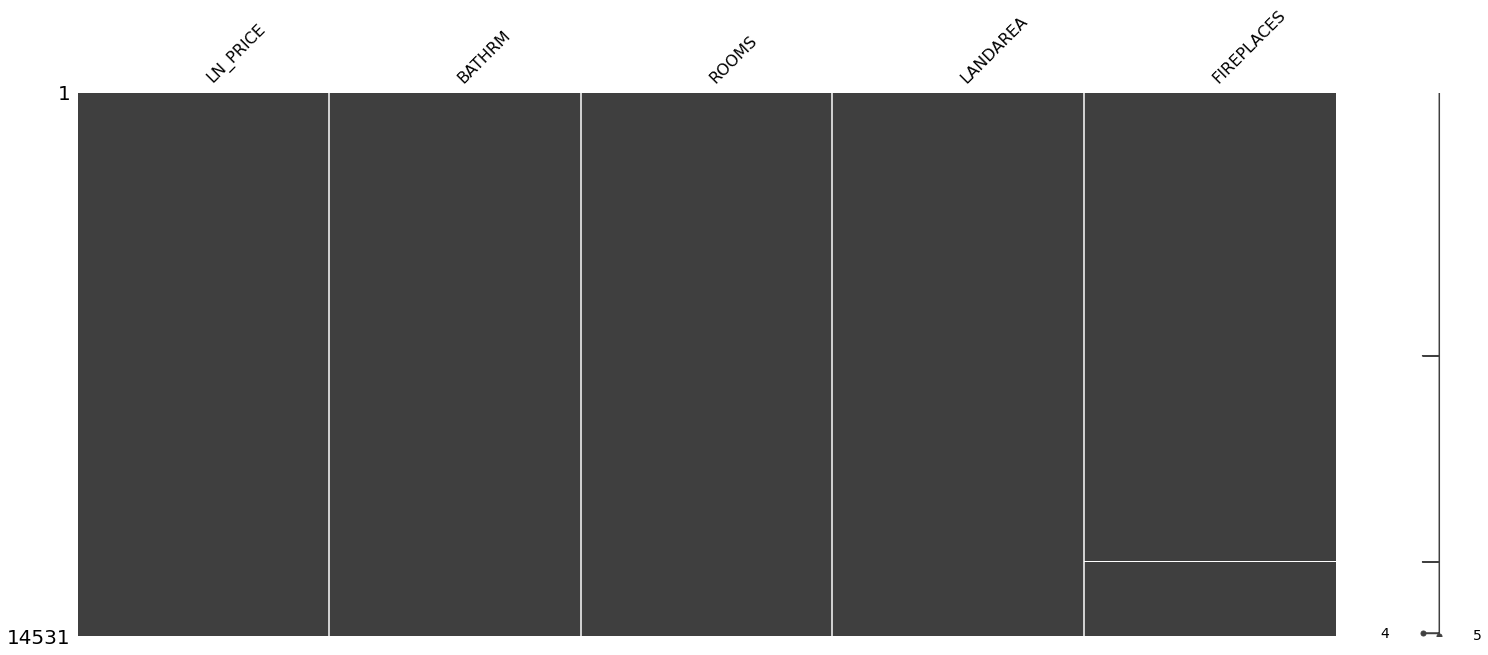

In [8]:
miss.matrix(test)

In [10]:
# Drop all nan values
train = train.dropna()
test = test.dropna()

In [15]:
test.shape

(14528, 5)

In [16]:
train.shape

(14528, 5)

In [20]:
test_X = test[['BATHRM','ROOMS','LANDAREA','FIREPLACES']] 
test_Y = test[['LN_PRICE']] 


train_X = train[['BATHRM','ROOMS','LANDAREA','FIREPLACES']] 
train_Y = train[['LN_PRICE']] 

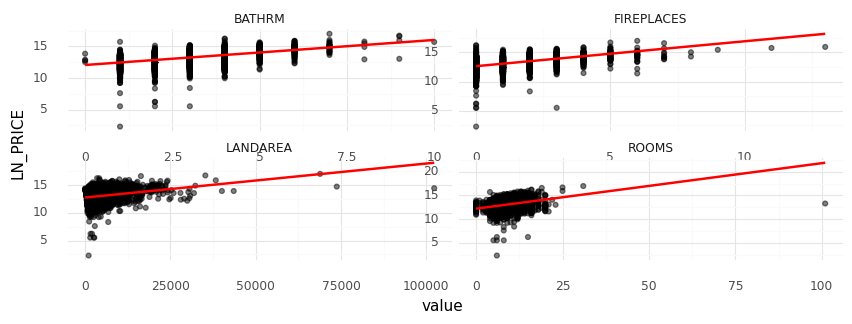

<ggplot: (8771138824223)>

In [22]:
D = train_X.copy()
D['LN_PRICE'] = train_Y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [23]:

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','ROOMS','LANDAREA','FIREPLACES'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
#a dictionary with all our different specifications
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_Y)

/Users/juliezantao/opt/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/Users/juliezantao/opt/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juliezantao/opt/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juliezantao/opt/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversion

/Users/juliezantao/opt/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juliezantao/opt/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juliezantao/opt/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juliezantao/opt/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConver

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'ROOMS',
                                                                          'LANDAREA',
                                                                          'FIREPLACES'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor(max_depth=5)],
                    

In [24]:
# Find the best fit score 
search.best_score_

-0.46491486845375346

In [25]:
# Find the best model
search.best_params_

{'model': DecisionTreeRegressor(max_depth=5), 'model__max_depth': 5}

In [26]:
# Predict() method will use the best model out of the scan
pred_Y = search.predict(test_X)

In [27]:
m.mean_squared_error(test_Y,pred_Y)

0.4516503632579453

In [28]:
m.r2_score(test_Y,pred_Y)

0.3892613218837694

In [32]:
(
    ggplot(pd.DataFrame(dict(pred=pred_Y,truth=test_Y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

ValueError: Data must be 1-dimensional